In [40]:
import pandas as pd
from scipy.interpolate import interp1d
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class Relay:
    # Класс релейных защит
    def __init__(self, relay_type, Ir=None, Tr=None, Ir2=None, Tr2=None):
        self.Ir = Ir
        self.Tr = Tr
        self.Ir2 = Ir2
        self.Tr2 = Tr2
        # Выбор типа реле
        if relay_type == 'РТ-40':
            self.relay_func = self._RT40
        elif relay_type == 'РТВ-1':
            self.relay_func = self._RT40
        elif relay_type == 'Сириус-2':
            self.relay_func = self._Sirius
        elif relay_type == 'ПКТ-20А':
            data = pd.read_excel('ПКТ-20А.xlsx')
            self.relay_func = interp1d(data['x'], data['y'], bounds_error=False)
    
    def eval(self, I):
        if isinstance(I, int) or isinstance(I, float):
            return self.relay_func(I)
        else:
            return np.array([self.relay_func(i) for i in I])

    def _RT40(self, i):
        #РТВ-1 - реле с замедлением
        if i > self.Ir:
            return self.Tr
            #return 1 / 30 / (i / self.Ir - 1)**3 + self.Tr
        else:
            return 1000

    def _Sirius(self, i):
        if i > self.Ir:
            t1 = (0.14 * self.Tr) / ((i / self.Ir)**0.02 - 1)
        else:
            t1 = np.inf
            
        if i > self.Ir2:
            t2 = self.Tr2
        else:
            t2 = np.inf
        return min([t1, t2])

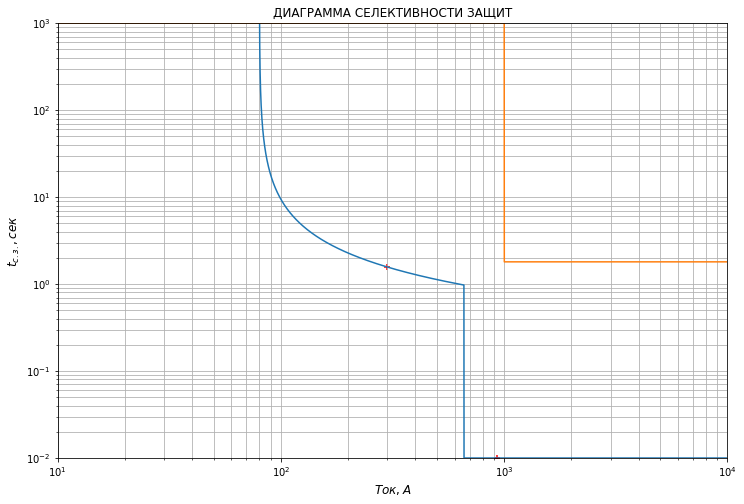

In [9]:
R1 = Relay('Сириус-2', 80, 0.3, 660, 0.01)
R2 = Relay('РТ-40', 1000, 1.8)

Ikz3 = 930
Ikz3_tr = 300

x = np.arange(10, 10000, 0.1)

plt.figure(figsize=(12,8))

plt.plot(x, R1.eval(x))
plt.plot(x, R2.eval(x))

plt.scatter(Ikz3, R1.eval(Ikz3), c='r', marker='+') #Iкз(3)
plt.scatter(Ikz3_tr, R1.eval(Ikz3_tr), c='r', marker='+') #Iкз(3) за трансформатором

plt.xlabel(r'$Ток, А$', fontsize=12)
plt.ylabel(r'$t_{с.з.}, сек$', fontsize=12)
plt.xscale('log')
plt.yscale('log')
plt.grid(which='both')
plt.ylim(0.01, 1000)
plt.xlim(10, 10000)
plt.title('ДИАГРАММА СЕЛЕКТИВНОСТИ ЗАЩИТ')
plt.savefig('E:\Проекты\ЭПВ-2019-06 КТП Бахрушиных\Диаграмма селективности.png', bbox_inches='tight', dpi=300)

In [41]:
R1.eval(Ikz3_tr)

1.5678882256036142

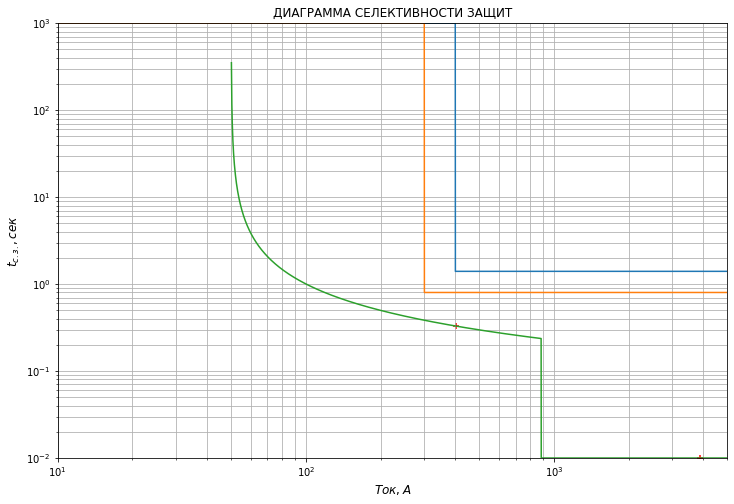

In [13]:
R1 = Relay('РТ-40', 400, 1.4)
R2 = Relay('РТ-40', 300, 0.8)
R3 = Relay('Сириус-2', 50, 0.1, 887.5, 0.01)


Ikz2_k4 = 402
Ikz3_k3 = 3890

x = np.arange(10, 10000, 0.1)

plt.figure(figsize=(12,8))

#plt.plot(x, R1.eval(x)*0.8)
#plt.plot(x, R1.eval(x) * 1.2)
plt.plot(x, R1.eval(x))
plt.plot(x, R2.eval(x))
plt.plot(x, R3.eval(x))

#plt.fill_between(x, y1=R3.eval(x)*0.8, y2=R3.eval(x)*1.2, color='g')

plt.scatter(Ikz2_k4, R3.eval(Ikz2_k4), marker='+',  c='r')
plt.scatter(Ikz3_k3, R3.eval(Ikz3_k3), marker='+', c='r')


plt.xlabel(r'$Ток, А$', fontsize=12)
plt.ylabel(r'$t_{с.з.}, сек$', fontsize=12)
plt.xscale('log')
plt.yscale('log')
plt.grid(which='both')
plt.ylim(0.01,1000)
plt.xlim(10, 5000)
plt.title('ДИАГРАММА СЕЛЕКТИВНОСТИ ЗАЩИТ')
plt.savefig('E:\Проекты\ЭПВ-2019-01 Горшково\Диаграмма селективности.png', bbox_inches='tight', dpi=300)

In [12]:
R3.eval(Ikz2_k4)

0.32887200563296093

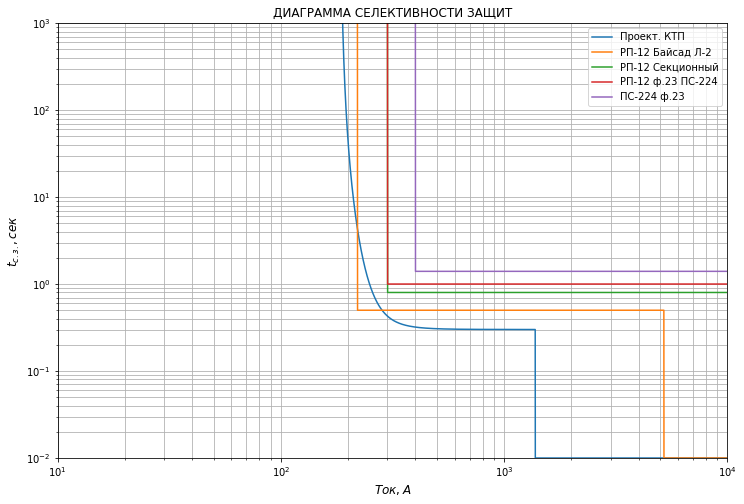

In [3]:
import numpy as np
import matplotlib.pyplot as plt


class Relay:
    """
    Класс защит типа реле - аналоговых или цифровых
    """

    def __init__(self, name,  stages: list):
        """
        Задание ступеней защит

        :param stages: tuple("тип ступени", (Ir, Tr))
        """
        self.name = name
        self.stages = stages

    def response_time(self, current):
        current = np.array(current, dtype=float)
        response = []
        for stage in self.stages:
            func_type, settings = stage
            stage_func = getattr(self, func_type)
            stage_response = stage_func(current, settings)
            response.append(stage_response)
        return np.min(response, axis=0)

    @staticmethod
    def independent(current, settings):
        """
        Независимая характеристика выдержки времени

        :param current: numpy array
        :param settings: tuple(Ir, Tr)
        :return: response_times: numpy array
        """
        Ir, Tr = settings
        response = np.piecewise(current, [current < Ir, current >= Ir], [10000, Tr])
        return response

    @staticmethod
    def rtv_4(current, settings):
        """
        Зависимая нормальная характеристика выдержки времени типа РТВ-4

        :param current: numpy array
        :param settings: tuple(Ir, Tr)
        :return: response_times: numpy array
        """
        Ir, Tr = settings
        func = lambda I: 1 / (20 * ((I / Ir - 1) / 6) ** 1.8) + Tr
        response = np.piecewise(current, [current < Ir, current >= Ir], [10000, func])
        return response

    @staticmethod
    def rtv_1(current, settings):
        """
        Зависимая характеристика выдержки времени типа РТВ-1

        :param current: numpy array
        :param settings: tuple(Ir, Tr)
        :return: response_times: numpy array
        """
        Ir, Tr = settings
        func = lambda I: 1 / (30 * (I / Ir - 1) ** 3) + Tr
        response = np.piecewise(current, [current < Ir, current >= Ir], [10000, func])
        return response


def plot_defense(scheme):
    """
    Диаграмма селективности защит
    :param scheme: список аппаратов защиты
    """
    x = np.arange(10, 10000, 0.1)
    plt.figure(figsize=(12, 8))
    [plt.plot(x, relay.response_time(x), label=relay.name) for relay in scheme]
    plt.xlabel(r'$Ток, А$', fontsize=12)
    plt.ylabel(r'$t_{с.з.}, сек$', fontsize=12)
    plt.xscale('log')
    plt.yscale('log')
    plt.grid(which='both')
    plt.ylim(0.01, 1000)
    plt.xlim(10, 10000)
    plt.title('ДИАГРАММА СЕЛЕКТИВНОСТИ ЗАЩИТ')
    plt.legend()
    #plt.savefig('Диаграмма селективности.png', bbox_inches='tight', dpi=300)
    plt.show()


# Пример
if __name__ == '__main__':
    scheme = [Relay('Проект. КТП', [('rtv_1', (183, 0.3)), ('independent', (1377, 0.01))]),
              Relay('РП-12 Байсад Л-2', [('independent', (220, 0.5)), ('independent', (5192, 0.01))]),
              Relay('РП-12 Секционный', [('independent', (300, 0.8))]),
              Relay('РП-12 ф.23 ПС-224', [('independent', (300, 1))]),
              Relay('ПС-224 ф.23', [('independent', (400, 1.4))])]
    plot_defense(scheme)

In [36]:
class CustomAV:
    """
    Класс защит 0,4 кВ
    """

    def __init__(self, name,  stages: list):
        """
        Задание ступеней защит

        :param stages: tuple("тип ступени", (Ir, Tr))
        """
        self.name = name
        self.stages = stages

    def response_time(self, current):
        current = np.array(current, dtype=float)
        response = []
        for stage in self.stages:
            func_type, settings = stage
            stage_func = getattr(self, func_type)
            stage_response = stage_func(current, settings)
            response.append(stage_response)
        return np.min(response, axis=0)

    @staticmethod
    def independent(current, settings):
        """
        Независимая характеристика выдержки времени

        :param current: numpy array
        :param settings: tuple(Ir, Tr)
        :return: response_times: numpy array
        """
        Ir, Tr = settings
        response = np.piecewise(current, [current < Ir, current >= Ir], [10000, Tr])
        return response
    
    @staticmethod
    def overload_csv(current, filename):
        """
        Перегрузка из файла csv
        """
        data = pd.read_excel(filename)
        func = interp1d(data['x'], data['y'], bounds_error=False)
        response = func(current)
        return response

In [2]:
class Microprocess:
    """
    Класс защит 0,4 кВ на микропроцессорных управлении
    """

    def __init__(self, name,  stages: list):
        """
        Задание ступеней защит

        :param stages: tuple("тип ступени", (Ir, Tr))
        """
        self.name = name
        self.stages = stages

    def response_time(self, current):
        current = np.array(current, dtype=float)
        response = []
        for stage in self.stages:
            func_type, settings = stage
            stage_func = getattr(self, func_type)
            stage_response = stage_func(current, settings)
            response.append(stage_response)
        return np.min(response, axis=0)

    @staticmethod
    def independent(current, settings):
        """
        Независимая характеристика выдержки времени

        :param current: numpy array
        :param settings: tuple(Ir, Tr)
        :return: response_times: numpy array
        """
        Ir, Tr = settings
        response = np.piecewise(current, [current < Ir, current >= Ir], [10000, Tr])
        return response
    
    @staticmethod
    def overload(current, settings):
        """
        Перегрузка

        :param current: numpy array
        :param settings: tuple(Ir, Tr)
        :return: response_times: numpy array
        """
        Ir, Tr = settings
        func = lambda I: ((1.5 * Ir / I)**2) * Tr
        response = np.piecewise(current, [current < Ir, current >= Ir], [10000, func])
        return response
    
    @staticmethod
    def inversely(current, settings):
        """
        Обратнозависимая характеристика

        :param current: numpy array
        :param settings: tuple(Ir, Tr)
        :return: response_times: numpy array
        """
        Ir, Tr = settings
        func = lambda I: ((8 * Ir / I)**2) * Tr
        response = np.piecewise(current, [current < Ir, current >= Ir], [10000, func])
        return response

In [54]:
import numpy as np
import matplotlib.pyplot as plt


class Relay:
    """
    Класс защит типа реле - аналоговых или цифровых
    """

    def __init__(self, name,  stages: list):
        """
        Задание ступеней защит

        :param stages: tuple("тип ступени", (Ir, Tr))
        """
        self.name = name
        self.stages = stages

    def response_time(self, current):
        current = np.array(current, dtype=float)
        response = []
        for stage in self.stages:
            func_type, settings = stage
            stage_func = getattr(self, func_type)
            stage_response = stage_func(current, settings)
            response.append(stage_response)
        return np.min(response, axis=0)

    @staticmethod
    def independent(current, settings):
        """
        Независимая характеристика выдержки времени

        :param current: numpy array
        :param settings: tuple(Ir, Tr)
        :return: response_times: numpy array
        """
        Ir, Tr = settings
        response = np.piecewise(current, [current < Ir, current >= Ir], [10000, Tr])
        return response

    @staticmethod
    def rtv_4(current, settings):
        """
        Зависимая нормальная характеристика выдержки времени типа РТВ-4

        :param current: numpy array
        :param settings: tuple(Ir, Tr)
        :return: response_times: numpy array
        """
        Ir, Tr = settings
        func = lambda I: 1 / (20 * ((I / Ir - 1) / 6) ** 1.8) + Tr
        response = np.piecewise(current, [current < Ir, current >= Ir], [10000, func])
        return response

    @staticmethod
    def rtv_1(current, settings):
        """
        Зависимая характеристика выдержки времени типа РТВ-1

        :param current: numpy array
        :param settings: tuple(Ir, Tr)
        :return: response_times: numpy array
        """
        Ir, Tr = settings
        func = lambda I: 1 / (30 * (I / Ir - 1) ** 3) + Tr
        response = np.piecewise(current, [current < Ir, current >= Ir], [10000, func])
        return response

In [67]:
def plot_defense(scheme):
    """
    Диаграмма селективности защит
    :param scheme: список аппаратов защиты
    """
    x_limit = 100000
    y_limit = 1000
    x = np.arange(10, x_limit, 0.1)
    plt.figure(figsize=(12, 8))
    [plt.plot(x, relay.response_time(x), label=relay.name) for relay in scheme]
    plt.xlabel(r'$Ток, А$', fontsize=12)
    plt.ylabel(r'$t_{с.з.}, сек$', fontsize=12)
    plt.xscale('log')
    plt.yscale('log')
    plt.grid(which='both')
    plt.ylim(0.01, y_limit)
    plt.xlim(10, x_limit)
    plt.title('ДИАГРАММА СЕЛЕКТИВНОСТИ ЗАЩИТ')
    plt.legend()
    plt.vlines([9600, 20000], 0.01, y_limit)
    #plt.savefig('Диаграмма селективности.png', bbox_inches='tight', dpi=300)
    plt.show()

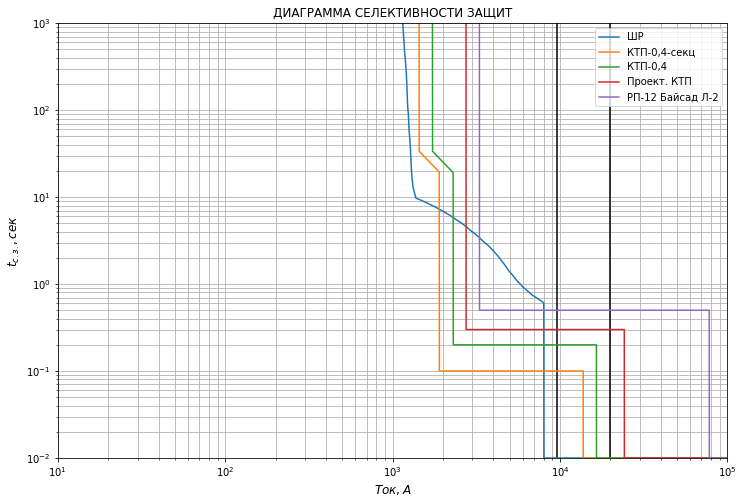

In [68]:
# Пример
if __name__ == '__main__':
    scheme = [
        CustomAV('ШР', [('overload_csv', 'ВА-99 1000А.xlsx'), ('independent', (8000, 0.01))]),
        Microprocess('КТП-0,4-секц', [('overload', (1440, 15)), ('independent', (1900, 0.1)), ('independent', (13750, 0.01))]),
        Microprocess('КТП-0,4', [('overload', (1730, 15)), ('independent', (2300, 0.2)), ('independent', (16500, 0.01))]),
        Relay('Проект. КТП', [('independent', (183*15, 0.3)), ('independent', (1614*15, 0.01))]),
        Relay('РП-12 Байсад Л-2', [('independent', (220*15, 0.5)), ('independent', (5192*15, 0.01))])
             ]
    plot_defense(scheme)